# __Home task: Pytorch__

In [130]:
import random
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

### __Load dataset__

In [131]:
class SignMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, transform = None):
        df = pd.read_csv(file_path)

        self.data = df.iloc[:, 1:].values
        self.target = df.iloc[:, 0]
        # Shifting letters after J by 1
        self.target = self.target.apply(lambda x: x if x < 9 else x - 1).values
        self.target_names = np.array([
            'A', 'B', 'C', 'D', 'E', 'F', 
            'G', 'H', 'I', 'K', 'L', 'M', 
            'N', 'O', 'P', 'Q', 'R', 'S', 
            'T', 'U', 'V', 'W', 'X', 'Y'
        ])
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        X = self.data[idx, :]
        X = X.reshape(28, 28)
        X = X.astype('float32')
        y = self.target[idx]
        
        if self.transform:
            X = self.transform(X)
            
        return X, y

In [132]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = SignMNISTDataset(
    file_path='./data/sign_mnist_train/sign_mnist_train.csv', 
    transform=transform
)
test_data = SignMNISTDataset(
    file_path='./data/sign_mnist_test/sign_mnist_test.csv', 
    transform=transform
)

In [133]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [134]:
input_size = train_data.data.shape[1]
output_size = len(train_data.target_names)

print("Input size:", input_size)
print("Output size:", output_size)

Input size: 784
Output size: 24


### __Train model__

In [135]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class SignMNISTModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = SignMNISTModel(input_size, output_size).to(device)
print(model)

SignMNISTModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=24, bias=True)
  )
)


In [136]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    model.train()

    size = len(dataloader.dataset) + 1
    num_batches = len(dataloader)

    loss_sum = 0
    accuracy_sum = 0
    
    tqdm_loader = tqdm(dataloader, unit="batch", desc=f"Epoch {epoch}", total=len(dataloader))
    for batch, (X, y) in enumerate(tqdm_loader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        accuracy = (pred.argmax(1) == y).type(torch.float).sum().item()

        loss_sum += loss.item()
        accuracy_sum += accuracy

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1000 == 0:
            tqdm_loader.set_postfix(loss=loss)
    
    return loss_sum / num_batches, accuracy_sum / size


def test_loop(dataloader, model, loss_fn):
    model.eval()

    size = len(dataloader.dataset) + 1
    num_batches = len(dataloader)
    
    loss_sum = 0
    accuracy_sum = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            accuracy = (pred.argmax(1) == y).type(torch.float).sum().item()

            loss_sum += loss.item()
            accuracy_sum += accuracy

    print(f"Test Error: \n Accuracy: {(100*(accuracy_sum/size)):>0.1f}%, Avg loss: {(loss_sum/num_batches):>8f} \n")
            
    return loss_sum / num_batches, accuracy_sum / size

In [137]:
epochs = 10

learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for t in range(epochs):
    _train_loss, _train_acc = train_loop(train_loader, model, loss_fn, optimizer, epoch=t)
    _test_loss, _test_acc = test_loop(test_loader, model, loss_fn)

    train_loss.append(_train_loss)
    train_accuracy.append(_train_acc)
    test_loss.append(_test_loss)
    test_accuracy.append(_test_acc)

# torch.save(model, 'model.pth')

Epoch 0: 100%|██████████| 858/858 [00:07<00:00, 112.10batch/s, loss=tensor(27.3239, grad_fn=<NllLossBackward0>)]


Test Error: 
 Accuracy: 43.4%, Avg loss: 1.871535 



Epoch 1: 100%|██████████| 858/858 [00:06<00:00, 122.66batch/s, loss=tensor(1.3422, grad_fn=<NllLossBackward0>)]


Test Error: 
 Accuracy: 66.6%, Avg loss: 1.100282 



Epoch 2: 100%|██████████| 858/858 [00:07<00:00, 119.23batch/s, loss=tensor(0.5983, grad_fn=<NllLossBackward0>)]


Test Error: 
 Accuracy: 68.6%, Avg loss: 0.953471 



Epoch 3: 100%|██████████| 858/858 [00:06<00:00, 126.73batch/s, loss=tensor(0.3082, grad_fn=<NllLossBackward0>)]


Test Error: 
 Accuracy: 70.8%, Avg loss: 0.885167 



Epoch 4: 100%|██████████| 858/858 [00:06<00:00, 127.48batch/s, loss=tensor(0.1450, grad_fn=<NllLossBackward0>)]


Test Error: 
 Accuracy: 72.3%, Avg loss: 0.894256 



Epoch 5: 100%|██████████| 858/858 [00:06<00:00, 123.48batch/s, loss=tensor(0.2230, grad_fn=<NllLossBackward0>)]


Test Error: 
 Accuracy: 77.2%, Avg loss: 0.863009 



Epoch 6: 100%|██████████| 858/858 [00:06<00:00, 126.35batch/s, loss=tensor(0.0432, grad_fn=<NllLossBackward0>)]


Test Error: 
 Accuracy: 78.9%, Avg loss: 0.758466 



Epoch 7: 100%|██████████| 858/858 [00:06<00:00, 124.43batch/s, loss=tensor(0.0368, grad_fn=<NllLossBackward0>)]


Test Error: 
 Accuracy: 73.1%, Avg loss: 1.055148 



Epoch 8: 100%|██████████| 858/858 [00:06<00:00, 131.37batch/s, loss=tensor(0.0540, grad_fn=<NllLossBackward0>)]


Test Error: 
 Accuracy: 78.6%, Avg loss: 0.823899 



Epoch 9: 100%|██████████| 858/858 [00:06<00:00, 131.02batch/s, loss=tensor(0.0108, grad_fn=<NllLossBackward0>)]


Test Error: 
 Accuracy: 80.2%, Avg loss: 0.806101 



### __Visualize training results__

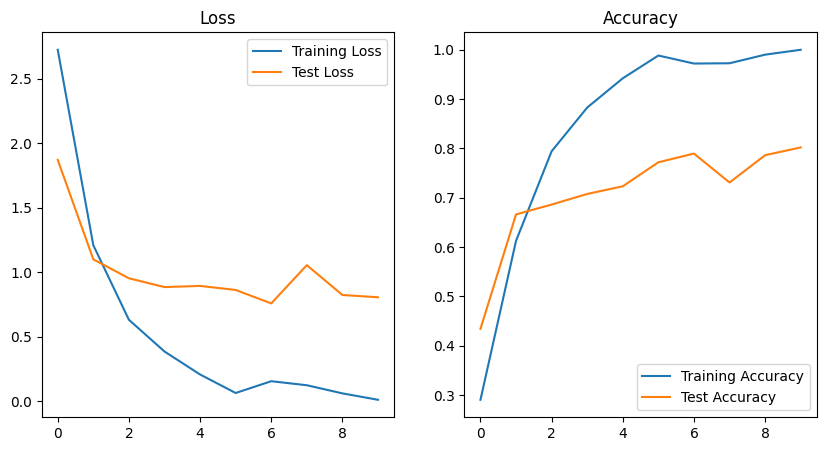

In [138]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

### __Predict 10 random images__

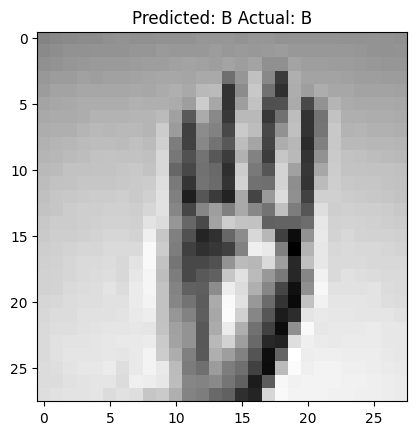

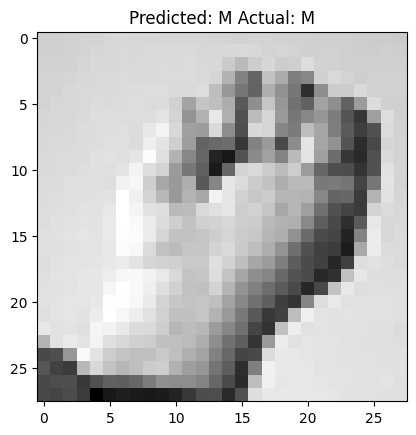

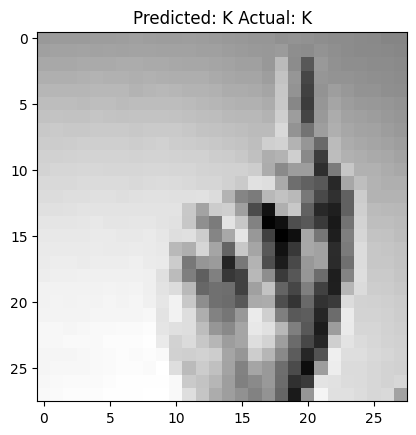

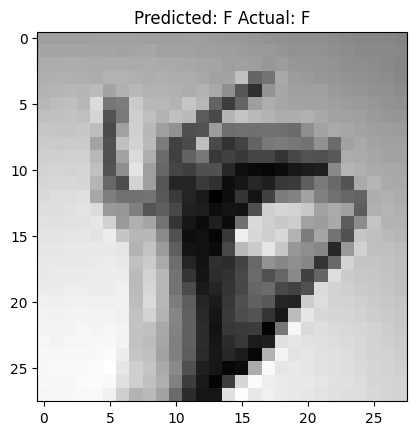

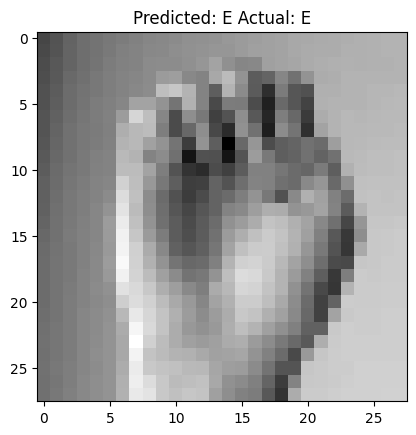

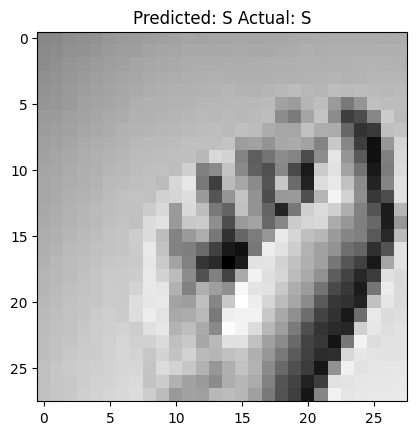

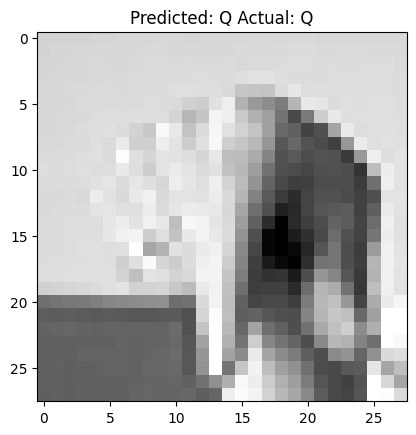

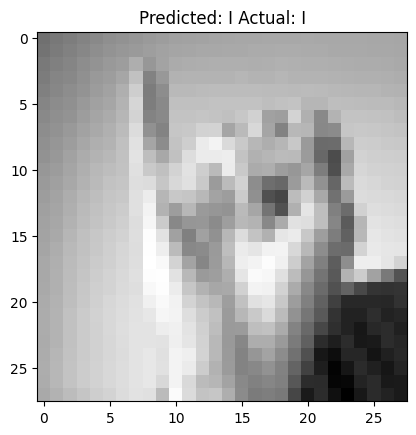

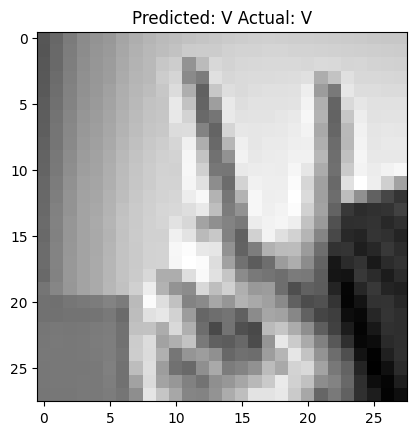

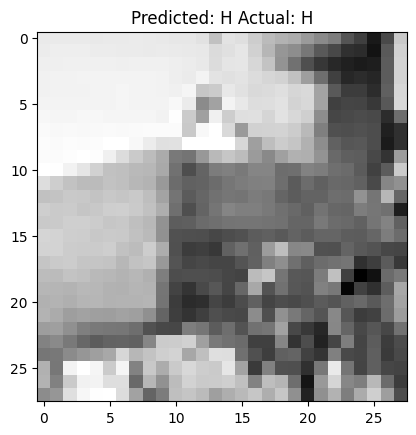

In [140]:
with torch.no_grad():
    for _ in range(10):
        X, y = test_data[random.randint(0, len(test_data))]
        pred = model(X)
        pred = pred.argmax(1)
        plt.title(f'Predicted: {train_data.target_names[pred]} Actual: {train_data.target_names[y]}')
        plt.imshow(X.squeeze(), cmap='gray')
        plt.show()